## Notebook: Analyze and Visualize Pair Statistics

### Purpose
This notebook analyzes pair statistics from various datasets and visualizes key metrics.



In [9]:
## Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Global configuration
BASE_PATH = "results_full"
TYPES = ['mast3r', 'lidar', 'mast3r_scaled_v3', 'mast3r_scaled_v4', 'mast3r_scaled_icp']
BIN_WIDTH = 100

In [10]:
from my_utils.evaluate import load_statistics
    
loaded_data = {}
for pointcloud_type in TYPES:
    df = load_statistics(pointcloud_type, BASE_PATH)
    if df is not None:
        # Convert numeric columns
        numeric_columns = ["num_matches", "num_inliers", "num_overlapping", "median_depth", 
                           "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                           "distance_anchor_query"]
        scale_cols = [col for col in df.columns if col.startswith("scale")]
        numeric_columns.extend(scale_cols)

        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
        
        loaded_data[pointcloud_type] = df

Loaded statistics for mast3r: 15 columns detected
Loaded statistics for lidar: 15 columns detected
Loaded statistics for mast3r_scaled_v3: 17 columns detected
Loaded statistics for mast3r_scaled_v4: 19 columns detected
Loaded statistics for mast3r_scaled_icp: 17 columns detected


In [11]:
top3_path = "/home/bjangley/VPR/mast3r-v2/mined_step50/spagna_matches_inliers_fm_top3_anchors_per_query_per_anchorseq.csv"
df = pd.read_csv(top3_path)
# # Group by anchor_seq and query_seq and count the number of pairs
# pair_counts = df.groupby(['anchor_seq', 'query_seq']).size().reset_index(name='num_pairs')

# # Print the counts
# print(pair_counts)
# print("Total number of pairs:", pair_counts['num_pairs'].sum())

# Group by anchor_seq and query_seq and compute median and mean for num_inliers
inliers_stats = df.groupby(['anchor_seq', 'query_seq'])['num_inliers'].agg(['mean', 'median']).reset_index()

# Print the results
print("Per Anchor-Query Sequence Median and Mean num_inliers:")
print(inliers_stats)

Per Anchor-Query Sequence Median and Mean num_inliers:
    anchor_seq  query_seq         mean  median
0            0          3  1142.383333  1392.5
1            0         10  1162.525000  1478.5
2            4          3   737.058333   724.5
3            4          5   568.775000   340.0
4            4         10   950.066667   875.5
5            4         11  1147.833333  1142.0
6            4         12   152.891667    99.5
7            4         19   580.333333   591.5
8            7         14   495.516667   273.5
9           13         15   776.158333  1029.5
10          20          2   956.008333   890.0
11          20         21   453.222222   362.0


/tmp/ipykernel_2639302/2945359462.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)


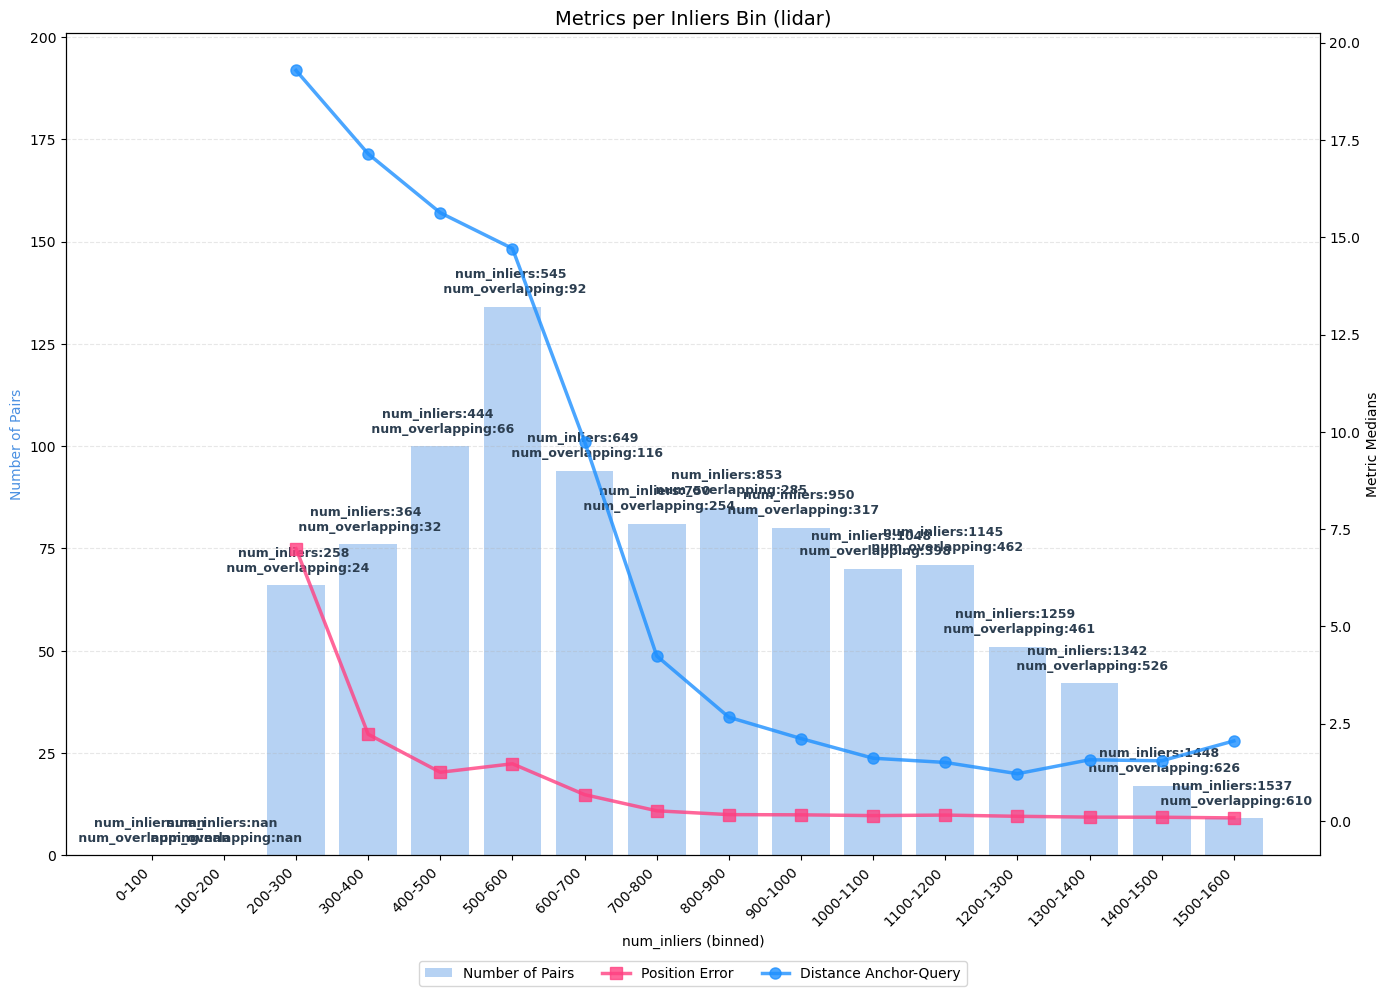

In [41]:
def plot_metrics_per_bin(dataset_to_plot, bin_by, metrics_to_plot, annotation_metrics):
    """
    Plot metrics per bin for a specific dataset, including bar plots for pair counts
    and line plots for metric medians.
    """
    df = loaded_data[dataset_to_plot]
    df_ok = df[df['status'] == 'OK']

    # Create bins based on the selected binning column
    bins = range(0, int(df_ok[bin_by].max()) + BIN_WIDTH, BIN_WIDTH)
    bin_column = f"{bin_by}_bin"
    df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)

    # Group by the bins and compute statistics
    grouped = df_ok.groupby(bin_column)
    count_by_bin = grouped.size()

    # Compute median for annotation metrics
    annotation_medians = {metric: grouped[metric].median() for metric in annotation_metrics if metric in df_ok.columns}

    # Compute median for each selected metric to plot
    metric_medians = {metric: grouped[metric].median() for metric in metrics_to_plot.keys() if metric in df_ok.columns}

    # Convert bin intervals to numeric values (midpoints)
    bin_midpoints = [interval.mid for interval in count_by_bin.index]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 10))

    # Bar plot: number of pairs per bin (left y-axis)
    bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=BIN_WIDTH * 0.8, alpha=0.4, label="Number of Pairs")
    ax1.set_ylabel("Number of Pairs", color="#4A90E2")
    ax1.set_xlabel(f"{bin_by} (binned)")
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], rotation=45, ha="right")
    ax1.set_ylim(0, max(count_by_bin) * 1.5)

    # Annotate bars with median values of selected metrics
    for i, bar in enumerate(bars):
        annotation_text = [f"{metric}:{annotation_medians[metric].iloc[i]:.0f}" for metric in annotation_metrics if metric in annotation_medians]
        if annotation_text:
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(count_by_bin) * 0.02, " \n ".join(annotation_text), ha="center", va="bottom", fontsize=9, color="#2C3E50", weight="bold")

    # Add line plots for metric medians (right y-axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Metric Medians", color="black")
    line_plots = []
    for metric, config in metrics_to_plot.items():
        if metric in metric_medians:
            line = ax2.plot(bin_midpoints, metric_medians[metric], 
                            color=config['color'], marker=config['marker'], 
                            label=config['label'], linewidth=2.5, markersize=8, alpha=0.8)
            line_plots.append((line[0], config['label']))

    # Combine legends
    legend_items = [(bars, "Number of Pairs")] + line_plots
    handles, labels = zip(*legend_items)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=min(len(handles), 4), fontsize=10)

    # Add grid lines
    ax1.grid(axis="y", linestyle="--", alpha=0.3)

    # Dynamic title based on binning variable
    bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
    plt.title(f"Metrics per {bin_label} Bin ({dataset_to_plot})", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_metrics_per_bin(
    dataset_to_plot='lidar',
    bin_by='num_inliers',
    metrics_to_plot={
        'pos_error': {'color': '#FF4081', 'marker': 's', 'label': 'Position Error'},
        'distance_anchor_query': {'color': '#1E90FF', 'marker': 'o', 'label': 'Distance Anchor-Query'},
    },
    annotation_metrics=['num_inliers', 'num_overlapping']
)

In [5]:



# Table 1: Success rate and num_inliers (median)
table1_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table1_data.append({
        'method': pointcloud_type,
        'n_success': len(ok_pairs),
        'n_total': len(df),
        'success_rate': len(ok_pairs) / len(df) if len(df) > 0 else 0,
        'num_inliers_median': ok_pairs['num_inliers'].median() if len(ok_pairs) > 0 else np.nan
    })

table1 = pd.DataFrame(table1_data)
print("Table 1: Success Rates and Inliers")
print(table1)
print()

# Table 2: Position and rotation errors (median)
table2_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table2_data.append({
        'method': pointcloud_type,
        'pos_error_median': ok_pairs['pos_error'].median() if len(ok_pairs) > 0 else np.nan,
        'x_error_median': ok_pairs['x_error'].median() if len(ok_pairs) > 0 else np.nan,
        'y_error_median': ok_pairs['y_error'].median() if len(ok_pairs) > 0 else np.nan,
        'z_error_median': ok_pairs['z_error'].median() if len(ok_pairs) > 0 else np.nan,
        'rot_error_median': ok_pairs['rot_error'].median() if len(ok_pairs) > 0 else np.nan
    })

table2 = pd.DataFrame(table2_data)
print("Table 2: Position and Rotation Errors (Median)")
print(table2.to_string(index=False))
print()

# Table 3: Distance and scales (mean and median)
table3_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    
    row = {
        'method': pointcloud_type,
        'distance_mean': ok_pairs['median_depth'].mean() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
        'distance_median': ok_pairs['median_depth'].median() if 'median_depth' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
    }
    
    # Add scale statistics
    if 'scale' in ok_pairs.columns:
        # row['scale_mean'] = ok_pairs['scale'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_median'] = ok_pairs['scale'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_x' in ok_pairs.columns:
        # row['scale_x_mean'] = ok_pairs['scale_x'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_x_median'] = ok_pairs['scale_x'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_y' in ok_pairs.columns:
        # row['scale_y_mean'] = ok_pairs['scale_y'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_y_median'] = ok_pairs['scale_y'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_z' in ok_pairs.columns:
        # row['scale_z_mean'] = ok_pairs['scale_z'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_z_median'] = ok_pairs['scale_z'].median() if len(ok_pairs) > 0 else np.nan
    
    table3_data.append(row)

table3 = pd.DataFrame(table3_data)
print("Table 3: Distance and Scale Statistics")
print(table3.to_string(index=False))

Table 1: Success Rates and Inliers
              method  n_success  n_total  success_rate  num_inliers_median
0             mast3r        980     1050      0.933333               727.5
1              lidar        976     1050      0.929524               729.5
2   mast3r_scaled_v3        980     1050      0.933333               727.5
3   mast3r_scaled_v4        977     1050      0.930476               729.0
4  mast3r_scaled_icp        980     1050      0.933333               727.5

Table 2: Position and Rotation Errors (Median)
           method  pos_error_median  x_error_median  y_error_median  z_error_median  rot_error_median
           mast3r          4.552076        2.154207        0.183453        2.612045          0.040018
            lidar          0.318327        0.137167        0.067806        0.201751          0.020245
 mast3r_scaled_v3          1.596723        0.402873        0.103082        1.225517          0.039864
 mast3r_scaled_v4          5.012357        1.817795        

In [6]:

dataset_to_analyze = 'lidar'  
target_bin_start = 800
target_bin_end = 1000

# Get the dataset
df = loaded_data[dataset_to_analyze]
df_ok = df[df['status'] == 'OK']

# Filter for the specific match range
matches_in_range = df_ok[(df_ok['num_matches'] >= target_bin_start) & (df_ok['num_matches'] < target_bin_end)]

print(f"Pairs with {target_bin_start}-{target_bin_end} matches in {dataset_to_analyze}:")
print(f"Number of pairs: {len(matches_in_range)}")
print()

# Show the indices and relevant information
if len(matches_in_range) > 0:
    relevant_cols = ['query_seq', 'anchor_seq', 'query_idx', 'anchor_idx','num_matches', 'num_overlapping', 'pos_error', 'distance_anchor_query', 'median_depth']
    display_data = matches_in_range[relevant_cols].sort_values('pos_error', ascending=False)
    
    print("Detailed breakdown:")
    print(display_data.to_string(index=False))
    
    # Summary statistics for this bin
    print(f"\nSummary statistics for {target_bin_start}-{target_bin_end} matches bin:")
    print(f"  Number of overlapping - Mean: {matches_in_range['distance_anchor_query'].mean():.1f}, Median: {matches_in_range['distance_anchor_query'].median():.1f}")
    
    # # Show the specific query and anchor indices
    # print(f"\nSpecific dataset indices:")
    # for _, row in matches_in_range.iterrows():
    #     print(f"  Query: seq={row['query_seq']}, idx={row['query_idx']} | Anchor: seq={row['anchor_seq']}, idx={row['anchor_idx']} | Matches: {row['num_matches']}")
else:
    print("No pairs found in this range")

Pairs with 800-1000 matches in lidar:
Number of pairs: 178

Detailed breakdown:
 query_seq  anchor_seq  query_idx  anchor_idx  num_matches  num_overlapping  pos_error  distance_anchor_query  median_depth
       3.0         4.0     6000.0      8800.0        853.0             50.0  51.322008              53.483288      5.794281
      19.0         4.0    39100.0      9700.0        807.0             18.0  51.154637              16.271812     19.752951
      19.0         4.0    38000.0      9700.0        948.0             15.0  32.868340              34.644902     27.994790
      19.0         4.0    38000.0      8000.0        839.0             12.0  29.803290              34.133429     19.300734
       3.0         4.0     6100.0      9000.0        833.0            216.0  25.193917              47.604880     20.909243
      10.0         4.0    20900.0      8800.0        813.0             86.0  23.458492              25.260546     31.063556
       3.0         4.0     6500.0      8800.0       

Using lidar as reference for binning
Binning by: num_inliers
Comparing metric: pos_error
Total pairs in reference: 1050, Successful pairs: 976


/tmp/ipykernel_2639302/1581570001.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_2639302/1581570001.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_2639302/1581570001.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

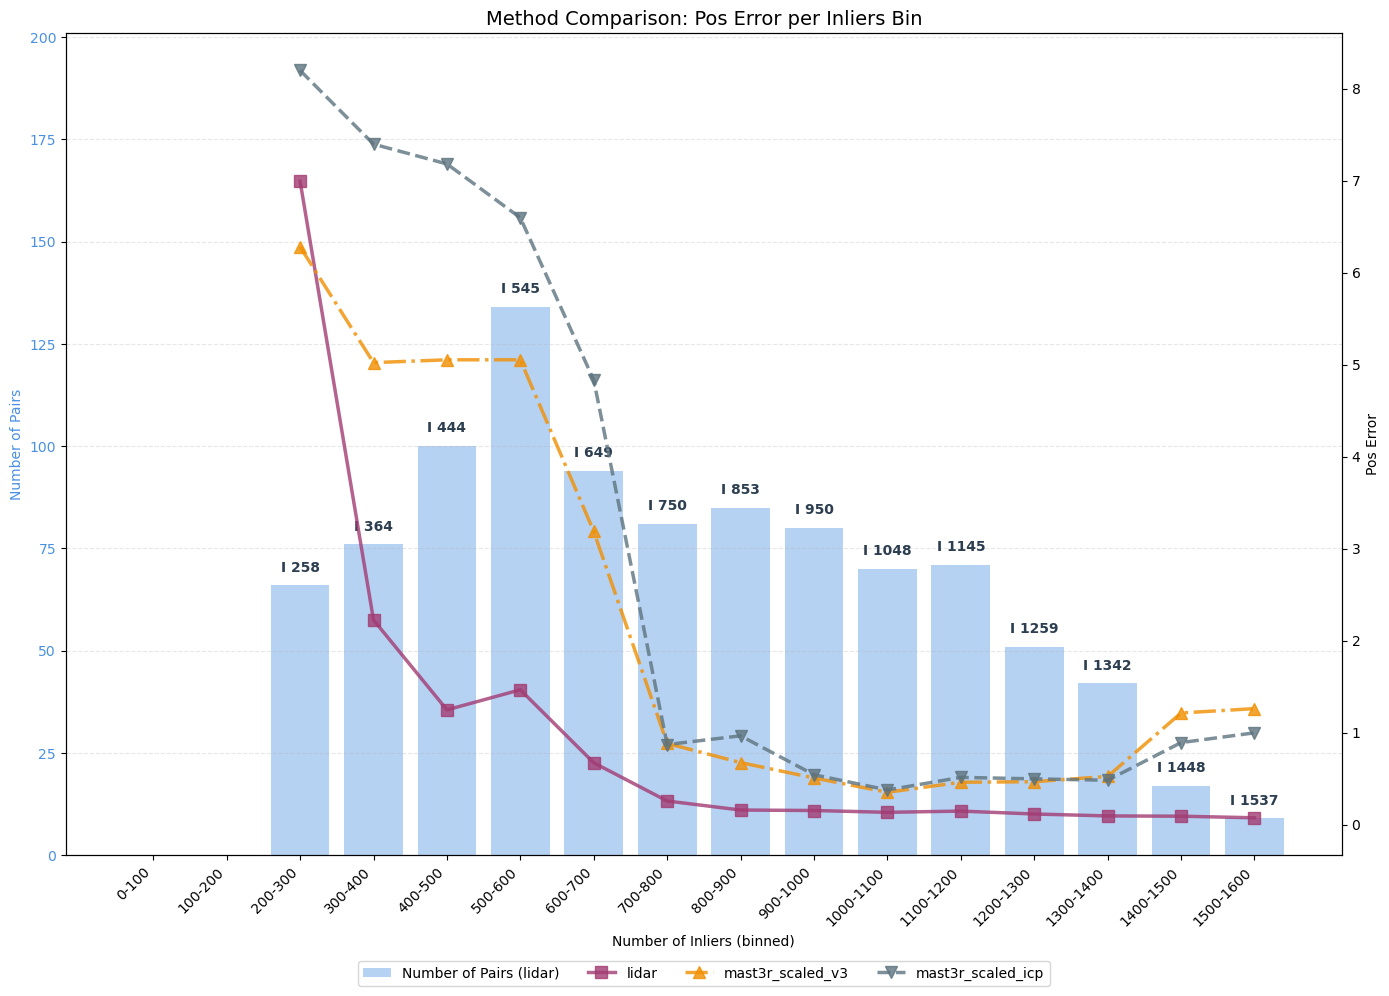


Comparison Statistics for pos_error:
lidar:
  Mean: 0.988
  Median: 0.157
  Min: 0.075
  Max: 6.994
mast3r_scaled_v3:
  Mean: 2.210
  Median: 1.049
  Min: 0.352
  Max: 6.280
mast3r_scaled_icp:
  Mean: 2.882
  Median: 0.929
  Min: 0.377
  Max: 8.198


In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
reference_dataset = 'lidar'  # Dataset to use for histogram/binning
bin_width = 100  # Adjust bin width as needed
bin_by = 'num_inliers'  # Change this to 'num_matches' or 'num_inliers'

# Choose which metric to compare across methods
metric_to_compare = 'pos_error'  # Change this to any metric you want to compare

# Choose which methods to compare (can select multiple)
methods_to_compare = {
    'lidar': {'color': '#A23B72', 'marker': 's', 'linestyle': '-'},            # Bright magenta
    'mast3r_scaled_v3': {'color': '#F18F01', 'marker': '^', 'linestyle': '-.'}, # Bright orange
    'mast3r_scaled_icp': {'color': '#5D737E', 'marker': 'v', 'linestyle': '--'}, # Bright teal
}

# Get the reference dataset for binning
df_ref = loaded_data[reference_dataset]
df_ref_ok = df_ref[df_ref['status'] == 'OK']

print(f"Using {reference_dataset} as reference for binning")
print(f"Binning by: {bin_by}")
print(f"Comparing metric: {metric_to_compare}")
print(f"Total pairs in reference: {len(df_ref)}, Successful pairs: {len(df_ref_ok)}")

# Validate binning column exists
if bin_by not in df_ref_ok.columns:
    raise ValueError(f"Error: Column '{bin_by}' not found in reference dataset!")

# Create bins based on reference dataset and selected binning column
bins = range(0, int(df_ref_ok[bin_by].max()) + bin_width, bin_width)
bin_column = f"{bin_by}_bin"
df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)

# Group reference data for histogram
grouped_ref = df_ref_ok.groupby(bin_column)
count_by_bin = grouped_ref.size()
median_inliers_by_bin = grouped_ref["num_inliers"].median()

# Convert bin intervals to numeric values (midpoints)
bin_midpoints = [interval.mid for interval in count_by_bin.index]

# Prepare data for all methods
method_data = {}
for method_name, config in methods_to_compare.items():
    if method_name in loaded_data:
        df = loaded_data[method_name]
        df_ok = df[df['status'] == 'OK']
        
        # Apply the same binning to this method's data
        df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
        grouped = df_ok.groupby(bin_column)
        
        # Compute the metric for this method
        if metric_to_compare in df_ok.columns:
            metric_values = grouped[metric_to_compare].median()
            # Reindex to match the reference bins (fill missing bins with NaN)
            metric_values = metric_values.reindex(count_by_bin.index)
            method_data[method_name] = metric_values
        else:
            print(f"Warning: {metric_to_compare} not found in {method_name}")

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 10))

# Bar plot: number of pairs per bin from reference dataset (left y-axis)
bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.4, 
               label=f"Number of Pairs ({reference_dataset})")
ax1.set_ylabel("Number of Pairs", color="#4A90E2")
ax1.tick_params(axis="y", labelcolor="#4A90E2")

# Dynamic x-axis label based on binning variable
x_label = "Number of Matches (binned)" if bin_by == 'num_matches' else "Number of Inliers (binned)"
ax1.set_xlabel(x_label)
ax1.set_xticks(bin_midpoints)
ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], 
                    rotation=45, ha="right")
ax1.set_ylim(0, max(count_by_bin) * 1.5)

# Annotate bars with median inliers from reference dataset
for i, (bar, median_inliers) in enumerate(zip(bars, median_inliers_by_bin)):
    if not pd.isna(median_inliers):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(count_by_bin) * 0.02,
            f"I {median_inliers:.0f}",
            ha="center", va="bottom", fontsize=10, color="#2C3E50", weight="bold"
        )

# Create secondary y-axis for the metric comparison
ax2 = ax1.twinx()
ax2.set_ylabel(f"{metric_to_compare.replace('_', ' ').title()}", color="black")

# Plot the metric for each method
line_plots = []
for method_name, config in methods_to_compare.items():
    if method_name in method_data:
        line = ax2.plot(bin_midpoints, method_data[method_name], 
                       color=config['color'], marker=config['marker'], 
                       linestyle=config['linestyle'], label=method_name,
                       linewidth=2.5, markersize=8, alpha=0.8)
        line_plots.append((line[0], method_name))

# Combine legends
legend_items = [(bars, f"Number of Pairs ({reference_dataset})")] + line_plots
handles, labels = zip(*legend_items)
ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
          ncol=min(len(handles), 4), fontsize=10)

# Add grid lines
ax1.grid(axis="y", linestyle="--", alpha=0.3)

# Dynamic title based on binning variable
bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
plt.title(f"Method Comparison: {metric_to_compare.replace('_', ' ').title()} per {bin_label} Bin", fontsize=14)
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nComparison Statistics for {metric_to_compare}:")
print("=" * 50)
for method_name in methods_to_compare.keys():
    if method_name in method_data:
        values = method_data[method_name].dropna()
        if len(values) > 0:
            print(f"{method_name}:")
            print(f"  Mean: {values.mean():.3f}")
            print(f"  Median: {values.median():.3f}")
            print(f"  Min: {values.min():.3f}")
            print(f"  Max: {values.max():.3f}")
        else:
            print(f"{method_name}: No data available")
    else:
        print(f"{method_name}: Not loaded")